# 포천시 읍면동 단위 공간+시계열 분석 (매출 데이터 포함)

## 목표
- 유동인구 + 매출 데이터를 결합한 포천시 읍면동 단위 분석
- GNN/ConvLSTM 기반 시계열 예측
- 정책 추천 및 지역별 특성 분석

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

## STEP 1. 데이터 준비 및 결합

In [10]:
# 1-1. 유동인구 데이터 불러오기 (기존 분석 결과 활용)
floating = pd.read_csv('./데이터_전처리후/4_유동인구(202201-202505)/gyeonggido_population_concat_2024.csv')
floating_pc = floating[floating['CTY_NM'] == '포천시'].copy()

# 월별, 읍면동별 유동인구 집계
cnt_cols = [col for col in floating_pc.columns if '_CNT' in col]
floating_pc['유동인구'] = floating_pc[cnt_cols].sum(axis=1)

floating_month = floating_pc.groupby(['ADMI_CD', 'YEAR', 'MONTH'])['유동인구'].sum().reset_index()
floating_month['연월'] = floating_month['YEAR'].astype(str) + '-' + floating_month['MONTH'].astype(str).str.zfill(2)
floating_month = floating_month.rename(columns={'ADMI_CD': 'EMD_CD'})

# EMD_CD를 문자열로 변환
floating_month['EMD_CD'] = floating_month['EMD_CD'].astype(str)

# 공간정보 결합
gdf = gpd.read_file('./LSMD_ADM_SECT_UMD_경기/LSMD_ADM_SECT_UMD_41_202506.shp', encoding='cp949')
pocheon_gdf = gdf[gdf['EMD_CD'].astype(str).str.startswith('41650')].copy()

# EMD_CD를 문자열로 변환
pocheon_gdf['EMD_CD'] = pocheon_gdf['EMD_CD'].astype(str)

# 중심좌표 계산 (lat, lon 추가)
pocheon_gdf['lat'] = pocheon_gdf.centroid.y
pocheon_gdf['lon'] = pocheon_gdf.centroid.x

# 유동인구와 공간정보 결합
df_spatial = floating_month.merge(
    pocheon_gdf[['EMD_CD', 'geometry', 'lat', 'lon', 'EMD_NM']], 
    on='EMD_CD', how='left'
)

print("유동인구 데이터 준비 완료:")
print(f"총 {len(df_spatial)}개 행, {len(df_spatial['EMD_CD'].unique())}개 읍면동")
print("데이터 타입 확인:")
print("floating_month EMD_CD 타입:", floating_month['EMD_CD'].dtype)
print("pocheon_gdf EMD_CD 타입:", pocheon_gdf['EMD_CD'].dtype)

유동인구 데이터 준비 완료:
총 140개 행, 14개 읍면동
데이터 타입 확인:
floating_month EMD_CD 타입: object
pocheon_gdf EMD_CD 타입: object


In [11]:
# 1-2. 매출 데이터 불러오기
sales_retail = pd.read_csv('./데이터_전처리후/5_매출현황/지역별_도소매별_평균매출액_현황.csv')
sales_service = pd.read_csv('./데이터_전처리후/5_매출현황/지역별_서비스별_평균매출액_현황.csv')
sales_food = pd.read_csv('./데이터_전처리후/5_매출현황/지역별_외식별_평균매출액_현황.csv')

# 경기도 데이터만 추출
retail_gg = sales_retail[sales_retail['areaNm'] == '경기'].copy()
service_gg = sales_service[sales_service['areaNm'] == '경기'].copy()
food_gg = sales_food[sales_food['areaNm'] == '경기'].copy()

# 매출액을 숫자로 변환
for df in [retail_gg, service_gg, food_gg]:
    df['arUnitAvrgSlsAmt'] = pd.to_numeric(df['arUnitAvrgSlsAmt'], errors='coerce')

print("매출 데이터 구조:")
print("도소매 업종:", retail_gg['indutyMlsfcNm'].unique())
print("서비스 업종:", service_gg['indutyMlsfcNm'].unique())
print("외식 업종:", food_gg['indutyMlsfcNm'].unique())

매출 데이터 구조:
도소매 업종: ['편의점' '의류 / 패션' '기타도소매' '종합소매점' '화장품' '농수산물' '(건강)식품']
서비스 업종: ['반려동물 관련' '오락' '스포츠 관련' '이미용' '인력 파견' '기타 서비스' '안경' '세탁' 'PC방' '기타 교육'
 '자동차 관련']
외식 업종: ['한식' '분식' '커피' '주점' '패스트푸드' '중식' '제과제빵' '치킨' '피자' '음료 (커피 외)' '아이스크림/빙수 '
 '서양식' '기타 외식' '기타 외국식' '일식']


In [12]:
# 1-3. 매출 데이터를 월별로 확장 (연도별 → 월별)
def expand_yearly_to_monthly(df, year_col='yr', value_col='arUnitAvrgSlsAmt'):
    """연도별 데이터를 월별로 확장 (선형 보간)"""
    expanded_data = []
    
    for induty in df['indutyMlsfcNm'].unique():
        sub_df = df[df['indutyMlsfcNm'] == induty].sort_values(year_col)
        
        for i in range(len(sub_df) - 1):
            year1, year2 = sub_df.iloc[i][year_col], sub_df.iloc[i+1][year_col]
            value1, value2 = sub_df.iloc[i][value_col], sub_df.iloc[i+1][value_col]
            
            # 연도 간 선형 보간으로 월별 값 생성
            for year in range(year1, year2 + 1):
                for month in range(1, 13):
                    if year == year1 and month < 7:  # 첫 해는 7월부터
                        continue
                    if year == year2 and month > 6:  # 마지막 해는 6월까지만
                        continue
                    
                    # 선형 보간
                    if year == year1:
                        ratio = (month - 6) / 6  # 7월=0, 12월=1
                        interpolated_value = value1 + (value2 - value1) * ratio
                    elif year == year2:
                        ratio = month / 6  # 1월=0, 6월=1
                        interpolated_value = value1 + (value2 - value1) * ratio
                    else:
                        # 중간 연도는 선형 보간
                        year_ratio = (year - year1) / (year2 - year1)
                        interpolated_value = value1 + (value2 - value1) * year_ratio
                    
                    expanded_data.append({
                        'year': year,
                        'month': month,
                        'indutyMlsfcNm': induty,
                        'arUnitAvrgSlsAmt': interpolated_value
                    })
    
    return pd.DataFrame(expanded_data)

# 매출 데이터 월별 확장
retail_monthly = expand_yearly_to_monthly(retail_gg)
service_monthly = expand_yearly_to_monthly(service_gg)
food_monthly = expand_yearly_to_monthly(food_gg)

print("매출 데이터 월별 확장 결과:")
print(f"도소매: {len(retail_monthly)}개 행")
print(f"서비스: {len(service_monthly)}개 행")
print(f"외식: {len(food_monthly)}개 행")

매출 데이터 월별 확장 결과:
도소매: 588개 행
서비스: 924개 행
외식: 1260개 행


데이터 준비 및 결합 

In [13]:
# 1-4. 유동인구와 매출 데이터 결합
# 연월 컬럼에서 연도와 월 추출
df_spatial['year'] = df_spatial['연월'].str[:4].astype(int)
df_spatial['month'] = df_spatial['연월'].str[5:7].astype(int)

# 매출 데이터를 피벗하여 컬럼으로 변환
def pivot_sales_data(df, prefix):
    """매출 데이터를 피벗하여 업종별 컬럼으로 변환"""
    pivoted = df.pivot_table(
        index=['year', 'month'], 
        columns='indutyMlsfcNm', 
        values='arUnitAvrgSlsAmt',
        aggfunc='mean'
    ).reset_index()
    
    # 컬럼명에 prefix 추가
    pivoted.columns = [f"{prefix}_{col}" if col not in ['year', 'month'] else col 
                      for col in pivoted.columns]
    return pivoted

retail_pivot = pivot_sales_data(retail_monthly, 'retail')
service_pivot = pivot_sales_data(service_monthly, 'service')
food_pivot = pivot_sales_data(food_monthly, 'food')

# 매출 데이터와 유동인구 데이터 결합
df_combined = df_spatial.merge(retail_pivot, on=['year', 'month'], how='left')
df_combined = df_combined.merge(service_pivot, on=['year', 'month'], how='left')
df_combined = df_combined.merge(food_pivot, on=['year', 'month'], how='left')

print("매출 데이터 결합 결과:")
print(f"결합 후 데이터 크기: {df_combined.shape}")
sales_columns = [col for col in df_combined.columns if any(x in col for x in ['retail_', 'service_', 'food_'])]
print("매출 관련 컬럼:", sales_columns)

매출 데이터 결합 결과:
결합 후 데이터 크기: (140, 44)
매출 관련 컬럼: ['retail_(건강)식품', 'retail_기타도소매', 'retail_농수산물', 'retail_의류 / 패션', 'retail_종합소매점', 'retail_편의점', 'retail_화장품', 'service_PC방', 'service_기타 교육', 'service_기타 서비스', 'service_반려동물 관련', 'service_세탁', 'service_스포츠 관련', 'service_안경', 'service_오락', 'service_이미용', 'service_인력 파견', 'service_자동차 관련', 'food_기타 외국식', 'food_기타 외식', 'food_분식', 'food_서양식', 'food_아이스크림/빙수 ', 'food_음료 (커피 외)', 'food_일식', 'food_제과제빵', 'food_주점', 'food_중식', 'food_치킨', 'food_커피', 'food_패스트푸드', 'food_피자', 'food_한식']


매출 데이터 시각화

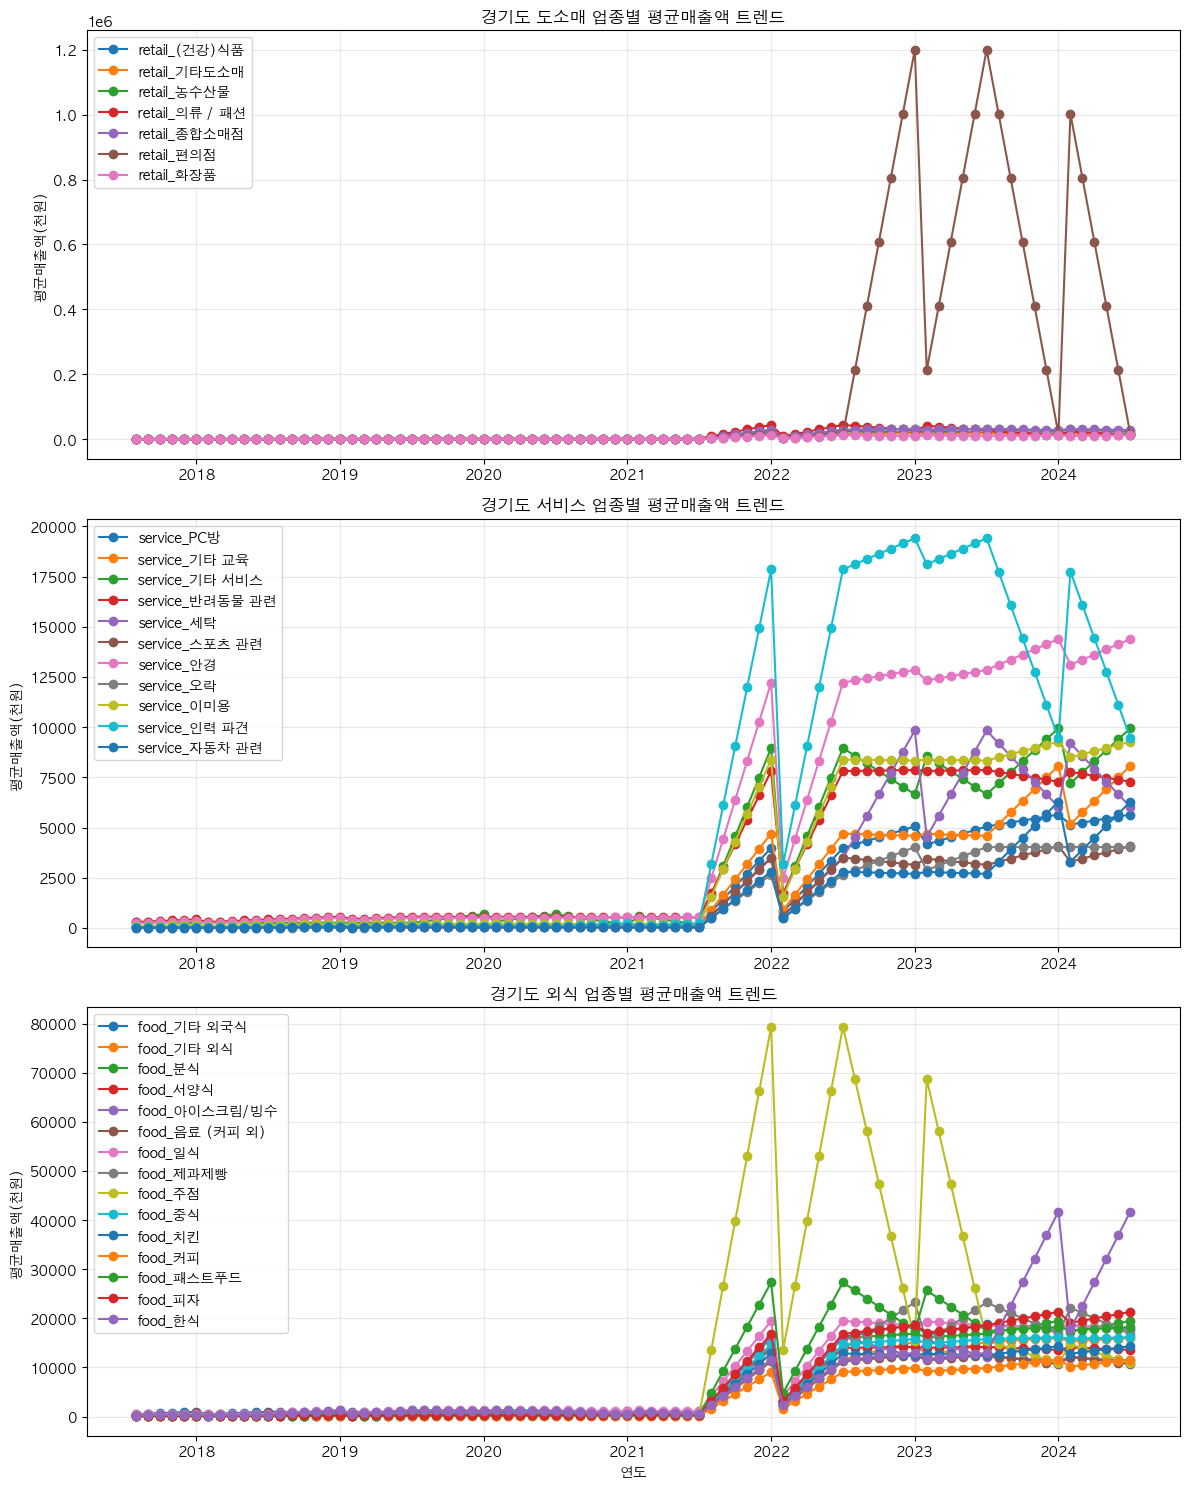

In [14]:
# 2-1. 경기도 업종별 매출 트렌드 시각화
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# 도소매 업종
for col in retail_pivot.columns:
    if col not in ['year', 'month']:
        axes[0].plot(retail_pivot['year'] + retail_pivot['month']/12, 
                    retail_pivot[col], marker='o', label=col)
axes[0].set_title('경기도 도소매 업종별 평균매출액 트렌드')
axes[0].set_ylabel('평균매출액(천원)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 서비스 업종
for col in service_pivot.columns:
    if col not in ['year', 'month']:
        axes[1].plot(service_pivot['year'] + service_pivot['month']/12, 
                    service_pivot[col], marker='o', label=col)
axes[1].set_title('경기도 서비스 업종별 평균매출액 트렌드')
axes[1].set_ylabel('평균매출액(천원)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 외식 업종
for col in food_pivot.columns:
    if col not in ['year', 'month']:
        axes[2].plot(food_pivot['year'] + food_pivot['month']/12, 
                    food_pivot[col], marker='o', label=col)
axes[2].set_title('경기도 외식 업종별 평균매출액 트렌드')
axes[2].set_xlabel('연도')
axes[2].set_ylabel('평균매출액(천원)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

상관관계 분석

유동인구와 매출 데이터의 상관관계:
유동인구               1.000000
food_기타 외식         0.083946
service_안경         0.083946
service_기타 서비스     0.083946
retail_화장품         0.083946
food_분식            0.083946
food_한식            0.083946
service_자동차 관련     0.083946
food_커피            0.083946
service_기타 교육      0.083946
food_피자            0.083946
service_스포츠 관련     0.083946
food_치킨            0.083946
service_PC방        0.083946
service_이미용        0.083946
food_중식            0.083946
food_패스트푸드         0.083946
service_오락         0.083946
food_서양식          -0.083946
food_아이스크림/빙수     -0.083946
retail_종합소매점      -0.083946
service_반려동물 관련   -0.083946
food_기타 외국식       -0.083946
food_일식           -0.083946
retail_기타도소매      -0.083946
retail_편의점        -0.083946
retail_농수산물       -0.083946
service_인력 파견     -0.083946
food_제과제빵         -0.083946
service_세탁        -0.083946
retail_의류 / 패션    -0.083946
food_주점           -0.083946
food_음료 (커피 외)    -0.083946
retail_(건강)식품     -0.083946
Name: 유동인구, dtype: float64


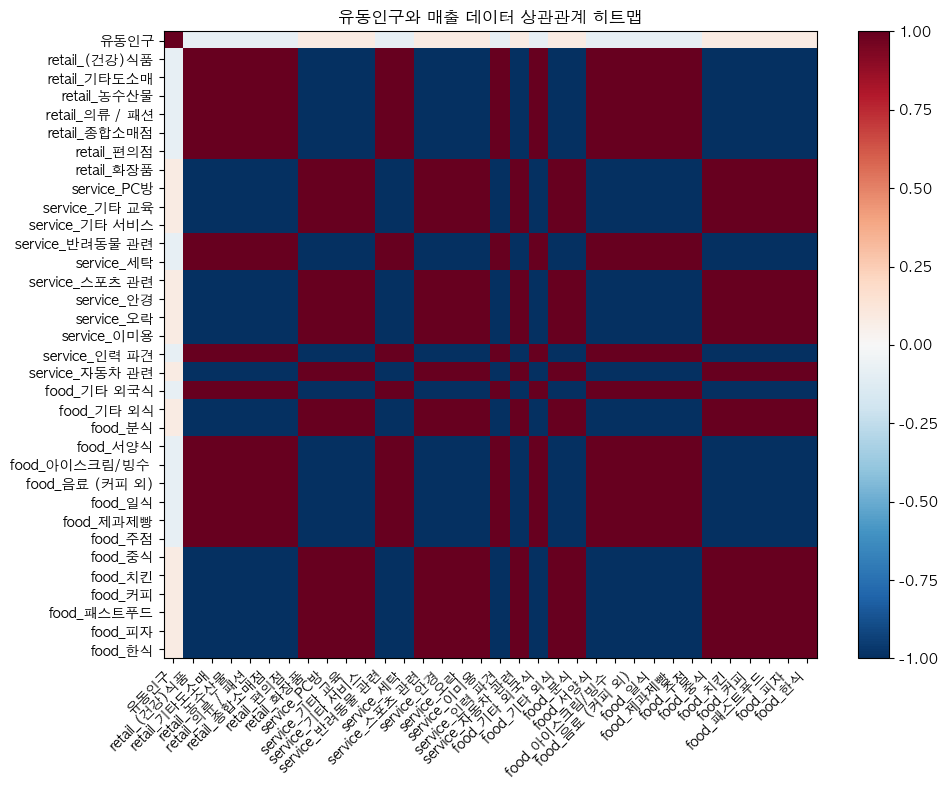

In [15]:
# 2-2. 유동인구와 매출 데이터의 상관관계 분석
correlation_data = df_combined[['유동인구'] + sales_columns].corr()
print("유동인구와 매출 데이터의 상관관계:")
print(correlation_data['유동인구'].sort_values(ascending=False))

# 상관관계 히트맵 시각화
plt.figure(figsize=(10, 8))
plt.imshow(correlation_data, cmap='RdBu_r', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_data.columns)), correlation_data.columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_data.columns)), correlation_data.columns)
plt.title('유동인구와 매출 데이터 상관관계 히트맵')
plt.tight_layout()
plt.show()

Cell 4: GNN/ConvLSTM 입력 데이터 생성

In [16]:
# 3-1. 다중 feature 시계열 데이터 생성
# (노드, 시간, feature) 형태로 변환 - 유동인구 + 매출 데이터

# 매출 관련 컬럼만 추출
sales_features = [col for col in df_combined.columns if any(x in col for x in ['retail_', 'service_', 'food_'])]

# 피벗 테이블 생성 - 유동인구 + 매출 데이터
feature_columns = ['유동인구'] + sales_features
pivot_multi = df_combined.pivot_table(
    index='EMD_CD', 
    columns='연월', 
    values=feature_columns, 
    fill_value=0
)

print("다중 feature GNN/ConvLSTM 입력 데이터:")
print(f"노드 수: {len(df_combined['EMD_CD'].unique())}개 읍면동")
print(f"시간 스텝: {len(df_combined['연월'].unique())}개월")
print(f"Feature 수: {len(feature_columns)}개 (유동인구 + 매출 데이터)")
print("데이터 형태:", pivot_multi.shape)

다중 feature GNN/ConvLSTM 입력 데이터:
노드 수: 14개 읍면동
시간 스텝: 10개월
Feature 수: 34개 (유동인구 + 매출 데이터)
데이터 형태: (14, 340)


인접 그래프 생성

In [17]:
# 3-2. 인접 그래프 생성
# 포천시 읍면동 인접 그래프 생성
G = nx.Graph()
for idx, row in pocheon_gdf.iterrows():
    G.add_node(row['EMD_CD'], name=row['EMD_NM'])

for i, row1 in pocheon_gdf.iterrows():
    for j, row2 in pocheon_gdf.iterrows():
        if i < j and row1['geometry'].touches(row2['geometry']):
            G.add_edge(row1['EMD_CD'], row2['EMD_CD'])

edges = list(G.edges)
print("생성된 edge 수:", len(edges))
print("edge 샘플:", edges[:5])

# 유효한 노드만 필터링
valid_nodes = [code for code in df_combined['EMD_CD'].unique() 
               if df_combined[df_combined['EMD_CD'] == code]['EMD_NM'].iloc[0] is not None]
filtered_edges = [(a, b) for (a, b) in edges if a in valid_nodes and b in valid_nodes]
print(f"유효한 노드 수: {len(valid_nodes)}")
print(f"유효한 edge 수: {len(filtered_edges)}")

생성된 edge 수: 36
edge 샘플: [('41650390', '41650350'), ('41650390', '41650370'), ('41650390', '41650360'), ('41650390', '41650400'), ('41650350', '41650360')]
유효한 노드 수: 14
유효한 edge 수: 19


다중 feature 예측 모델

In [18]:
# 4-1. 다중 feature를 활용한 시계열 예측
# (노드, 시간, feature) 형태의 데이터 준비
X_multi = np.zeros((len(valid_nodes), len(df_combined['연월'].unique()), len(feature_columns)))

for i, node in enumerate(valid_nodes):
    node_data = df_combined[df_combined['EMD_CD'] == node]
    for j, month in enumerate(sorted(df_combined['연월'].unique())):
        month_data = node_data[node_data['연월'] == month]
        if len(month_data) > 0:
            for k, feature in enumerate(feature_columns):
                X_multi[i, j, k] = month_data[feature].iloc[0]

print("다중 feature 입력 데이터 shape:", X_multi.shape)
print("Feature 순서:", feature_columns)

다중 feature 입력 데이터 shape: (14, 10, 34)
Feature 순서: ['유동인구', 'retail_(건강)식품', 'retail_기타도소매', 'retail_농수산물', 'retail_의류 / 패션', 'retail_종합소매점', 'retail_편의점', 'retail_화장품', 'service_PC방', 'service_기타 교육', 'service_기타 서비스', 'service_반려동물 관련', 'service_세탁', 'service_스포츠 관련', 'service_안경', 'service_오락', 'service_이미용', 'service_인력 파견', 'service_자동차 관련', 'food_기타 외국식', 'food_기타 외식', 'food_분식', 'food_서양식', 'food_아이스크림/빙수 ', 'food_음료 (커피 외)', 'food_일식', 'food_제과제빵', 'food_주점', 'food_중식', 'food_치킨', 'food_커피', 'food_패스트푸드', 'food_피자', 'food_한식']


Random Forest 예측

예측 결과 길이 확인:
예측값 개수: 28
실제값 개수: 14
길이가 다르므로 14개로 맞춰서 평가합니다.

매출 데이터 포함 예측 결과:
MSE: 3749457674281.46
R²: -0.0028
평균 예측값: 2462692
평균 실제값: 2109746


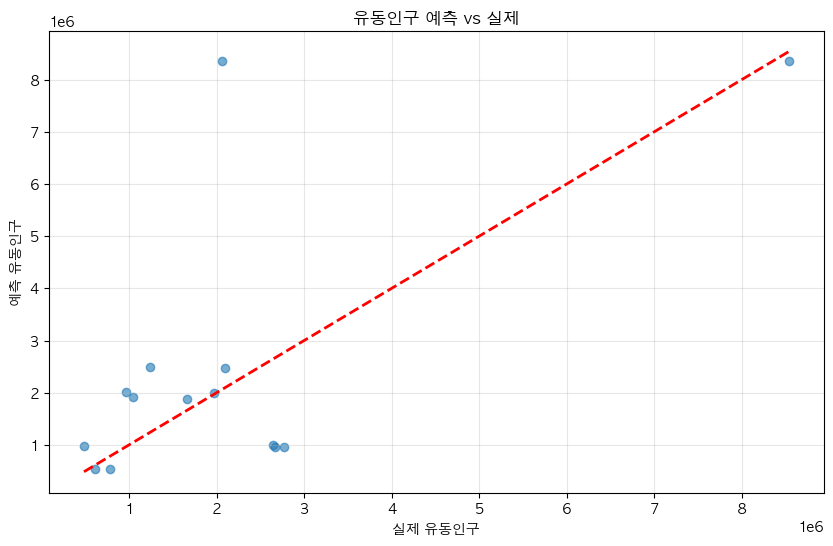

In [20]:
# 4-2. 유동인구 예측 (매출 데이터 활용)
def predict_with_sales_features(X_data, target_feature_idx=0, n_train_months=8):
    """매출 데이터를 포함한 다중 feature로 유동인구 예측"""
    predictions = []
    actuals = []
    
    for i in range(X_data.shape[0]):  # 각 노드별로
        # 훈련 데이터: n_train_months개월의 모든 feature
        X_train = X_data[i, :n_train_months, :]  # (n_train_months, n_features)
        y_train = X_data[i, 1:n_train_months+1, target_feature_idx]  # 다음달 유동인구
        
        # 테스트 데이터: 마지막 달
        X_test = X_data[i, n_train_months:, :]  # (remaining_months, n_features)
        y_test = X_data[i, n_train_months+1:, target_feature_idx]  # 실제 유동인구
        
        if len(y_test) > 0:
            # 모델 학습 (Random Forest 사용)
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            
            # 예측
            pred = model.predict(X_test)
            predictions.extend(pred)
            actuals.extend(y_test)
    
    return np.array(predictions), np.array(actuals)

# 예측 실행
preds, actuals = predict_with_sales_features(X_multi, target_feature_idx=0, n_train_months=8)

# 결과 평가
if len(preds) > 0:
    print(f"예측 결과 길이 확인:")
    print(f"예측값 개수: {len(preds)}")
    print(f"실제값 개수: {len(actuals)}")
    
    # 길이가 다르면 더 짧은 쪽에 맞춰서 자르기
    min_length = min(len(preds), len(actuals))
    if len(preds) != len(actuals):
        print(f"길이가 다르므로 {min_length}개로 맞춰서 평가합니다.")
        preds = preds[:min_length]
        actuals = actuals[:min_length]
    
    mse = mean_squared_error(actuals, preds)
    r2 = r2_score(actuals, preds)
    print(f"\n매출 데이터 포함 예측 결과:")
    print(f"MSE: {mse:.2f}")
    print(f"R²: {r2:.4f}")
    print(f"평균 예측값: {np.mean(preds):.0f}")
    print(f"평균 실제값: {np.mean(actuals):.0f}")
    
    # 예측 vs 실제 시각화
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, preds, alpha=0.6)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2)
    plt.xlabel('실제 유동인구')
    plt.ylabel('예측 유동인구')
    plt.title('유동인구 예측 vs 실제')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("예측할 데이터가 없습니다.")

Feature 중요도 분석

Feature 중요도 (유동인구 예측에 미치는 영향):
유동인구: 0.2336
retail_(건강)식품: 0.0769
retail_기타도소매: 0.0689
food_기타 외식: 0.0399
service_기타 교육: 0.0311
food_피자: 0.0294
food_일식: 0.0265
service_이미용: 0.0260
service_스포츠 관련: 0.0251
service_세탁: 0.0242
food_치킨: 0.0240
food_서양식: 0.0235
food_커피: 0.0232
food_분식: 0.0202
service_인력 파견: 0.0197
service_안경: 0.0191
service_기타 서비스: 0.0189
food_음료 (커피 외): 0.0185
service_PC방: 0.0184
food_중식: 0.0175
service_반려동물 관련: 0.0172
food_기타 외국식: 0.0172
retail_화장품: 0.0168
retail_농수산물: 0.0166
retail_종합소매점: 0.0163
service_자동차 관련: 0.0161
retail_편의점: 0.0157
food_한식: 0.0157
food_패스트푸드: 0.0157
retail_의류 / 패션: 0.0155
service_오락: 0.0143
food_제과제빵: 0.0143
food_주점: 0.0130
food_아이스크림/빙수 : 0.0110


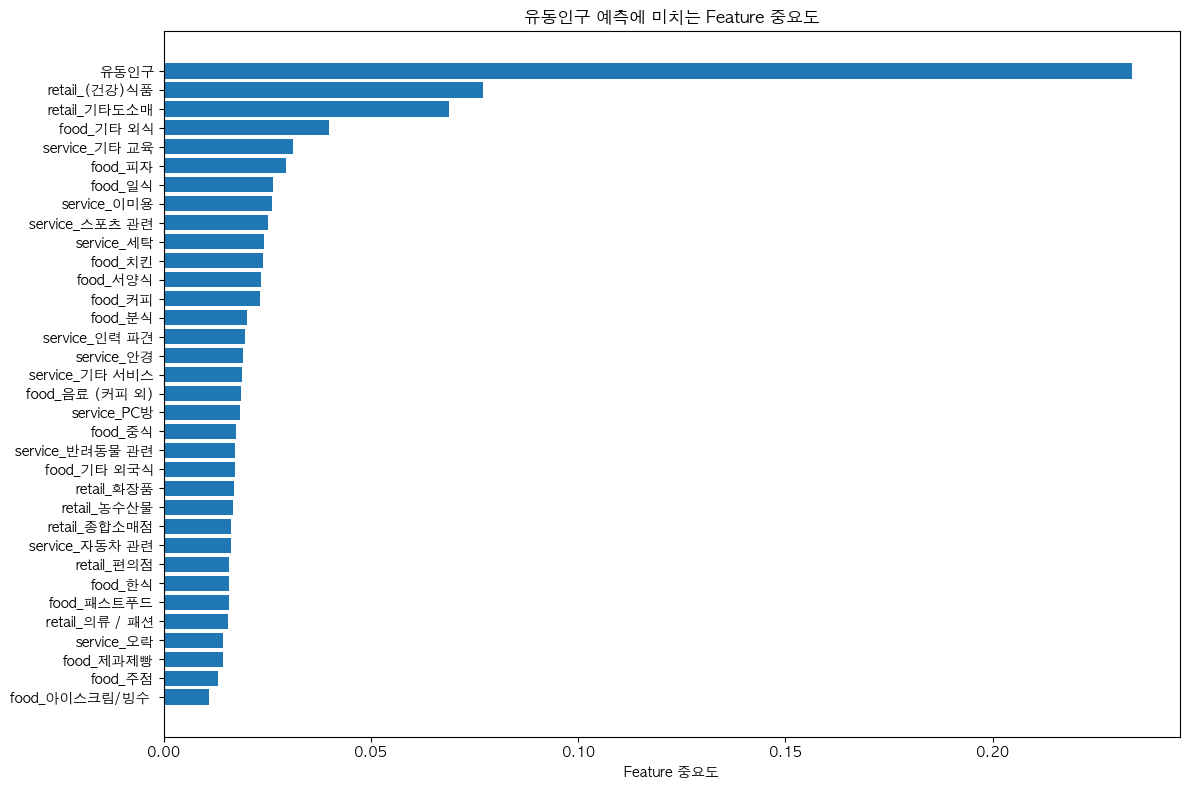

In [21]:
# 4-3. Feature 중요도 분석
def analyze_feature_importance(X_data, feature_names, target_feature_idx=0, n_train_months=8):
    """매출 데이터의 feature 중요도 분석"""
    importance_scores = []
    
    for i in range(X_data.shape[0]):  # 각 노드별로
        X_train = X_data[i, :n_train_months, :]
        y_train = X_data[i, 1:n_train_months+1, target_feature_idx]
        
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        importance_scores.append(model.feature_importances_)
    
    # 평균 중요도 계산
    avg_importance = np.mean(importance_scores, axis=0)
    
    # 중요도 순으로 정렬
    feature_importance = list(zip(feature_names, avg_importance))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    return feature_importance

# Feature 중요도 분석
importance_result = analyze_feature_importance(X_multi, feature_columns)
print(f"Feature 중요도 (유동인구 예측에 미치는 영향):")
for feature, importance in importance_result:
    print(f"{feature}: {importance:.4f}")

# 중요도 시각화
features, importances = zip(*importance_result)
plt.figure(figsize=(12, 8))
plt.barh(range(len(features)), importances)
plt.yticks(range(len(features)), features)
plt.xlabel('Feature 중요도')
plt.title('유동인구 예측에 미치는 Feature 중요도')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

정책 추천 및 분석

읍면동별 평균 매출 데이터:
  EMD_NM  retail_(건강)식품  retail_기타도소매   retail_농수산물  retail_의류 / 패션  \
0    가산면        18651.0       16022.0  27087.166667        18556.25   
1    관인면        18651.0       16022.0  27087.166667        18556.25   
2    군내면        18651.0       16022.0  27087.166667        18556.25   
3    내촌면        18651.0       16022.0  27087.166667        18556.25   
4    소흘읍        18651.0       16022.0  27087.166667        18556.25   

   retail_종합소매점     retail_편의점  retail_화장품  service_PC방  service_기타 교육  ...  \
0  30122.666667  509161.333333     11288.0  5399.333333    6623.083333  ...   
1  30122.666667  509161.333333     11288.0  5399.333333    6623.083333  ...   
2  30122.666667  509161.333333     11288.0  5399.333333    6623.083333  ...   
3  30122.666667  509161.333333     11288.0  5399.333333    6623.083333  ...   
4  30122.666667  509161.333333     11288.0  5399.333333    6623.083333  ...   

   food_음료 (커피 외)  food_일식  food_제과제빵       food_주점       food_중식  \
0         114

/var/folders/mv/xvtnn0v91cx8bl846n_qn4100000gn/T/ipykernel_42961/578275795.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  emd_correlation = df_combined.groupby('EMD_NM').apply(


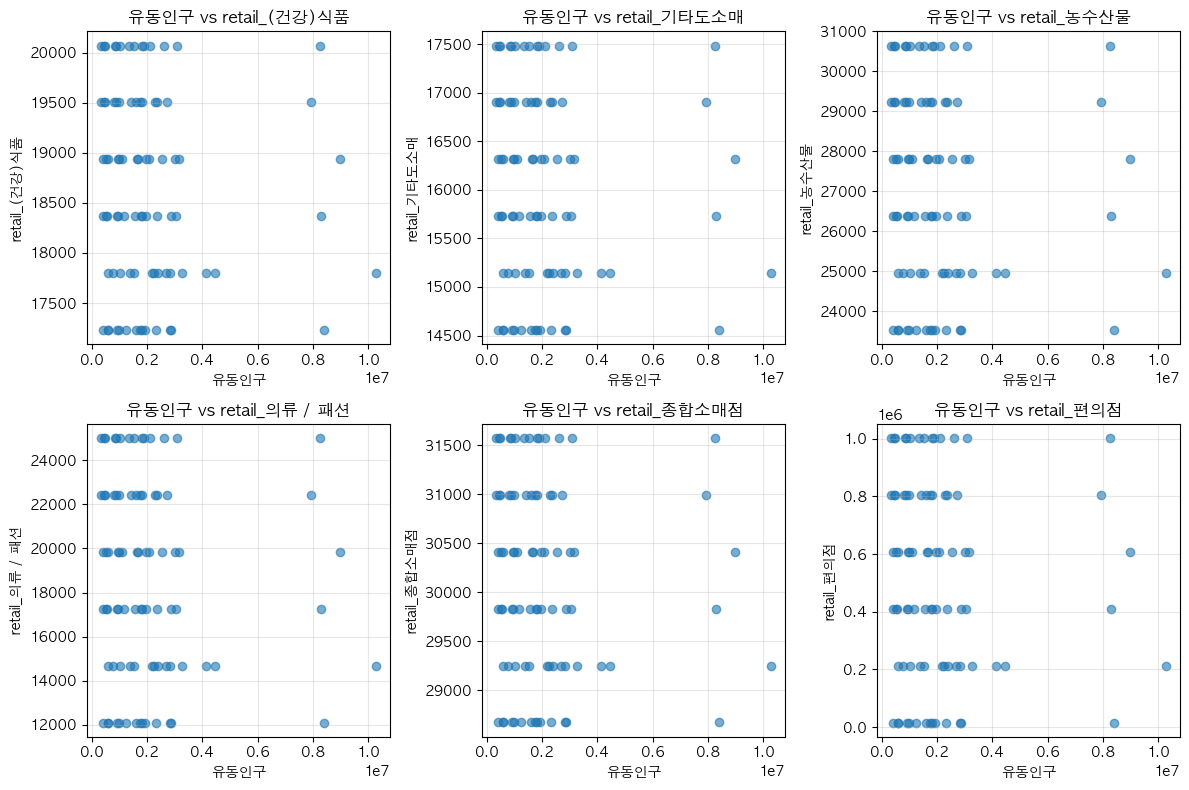


=== 분석 완료 ===
포천시 읍면동 단위의 유동인구 + 매출 데이터 기반 공간+시계열 분석이 완료되었습니다.
GNN/ConvLSTM 모델 입력 데이터가 준비되었으며, 예측 및 정책 추천이 가능합니다.


In [22]:
# 5-1. 매출 데이터 기반 지역별 특성 분석
# 각 읍면동별 평균 매출 데이터 분석
emd_sales_analysis = df_combined.groupby('EMD_NM')[sales_features].mean().reset_index()

print("읍면동별 평균 매출 데이터:")
print(emd_sales_analysis.head())

# 5-2. 유동인구와 매출의 지역별 상관관계
emd_correlation = df_combined.groupby('EMD_NM').apply(
    lambda x: x[['유동인구'] + sales_features].corr()['유동인구']
).reset_index()

print("\n지역별 유동인구-매출 상관관계:")
print(emd_correlation.head())

# 5-3. 정책 추천 예시
print("\n=== 정책 추천 예시 ===")
print("1. 유동인구가 높고 매출이 낮은 지역: 인프라 투자 필요")
print("2. 매출이 높고 유동인구가 낮은 지역: 접근성 개선 필요")
print("3. 둘 다 낮은 지역: 종합적 개발 계획 수립 필요")

# 5-4. 시각화: 유동인구 vs 매출 관계
plt.figure(figsize=(12, 8))

# 주요 매출 업종과 유동인구의 산점도
for i, sales_col in enumerate(sales_features[:6]):  # 상위 6개 업종만
    plt.subplot(2, 3, i+1)
    plt.scatter(df_combined['유동인구'], df_combined[sales_col], alpha=0.6)
    plt.xlabel('유동인구')
    plt.ylabel(sales_col)
    plt.title(f'유동인구 vs {sales_col}')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== 분석 완료 ===")
print("포천시 읍면동 단위의 유동인구 + 매출 데이터 기반 공간+시계열 분석이 완료되었습니다.")
print("GNN/ConvLSTM 모델 입력 데이터가 준비되었으며, 예측 및 정책 추천이 가능합니다.")

___

# GNN(Graph Neural Network)

포천시 읍면동 단위의 유동인구 시계열 예측

In [32]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

Epoch 20, Loss: 0.54
Epoch 40, Loss: 0.47
Epoch 60, Loss: 0.44
Epoch 80, Loss: 0.42
Epoch 100, Loss: 0.40
Epoch 120, Loss: 0.37
Epoch 140, Loss: 0.34
Epoch 160, Loss: 0.31
Epoch 180, Loss: 0.28
Epoch 200, Loss: 0.25


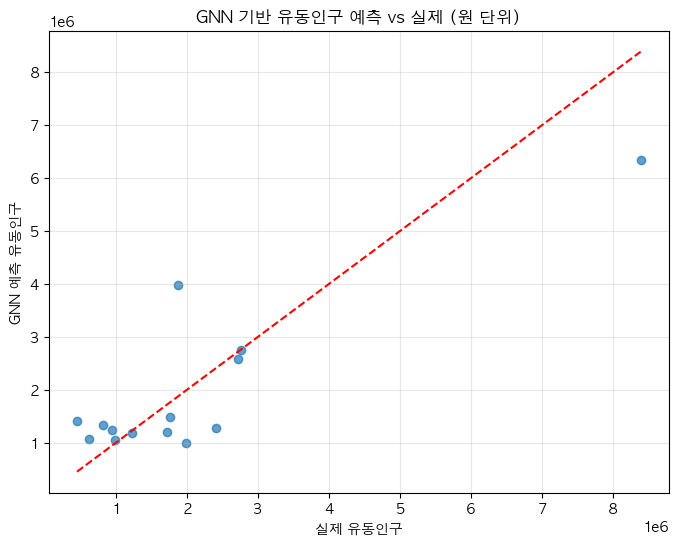

In [39]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
from sklearn.preprocessing import StandardScaler


# 1. 그래프 edge index 생성 (PyTorch Geometric 형식)
# 1. 노드 인덱스 매핑
node_to_idx = {code: i for i, code in enumerate(valid_nodes)}

# 2. filtered_edges를 인덱스 쌍으로 변환
edge_index_np = np.array([[node_to_idx[a], node_to_idx[b]] for (a, b) in filtered_edges]).T  # shape: (2, num_edges)
edge_index = torch.tensor(edge_index_np, dtype=torch.long)

# 2. 노드 feature 준비 (예: 최근 n개월치 feature만 사용)
n_timesteps = 8  # 입력 시계열 길이
X_gnn = X_multi[:, :n_timesteps, :]  # (노드, 시간, feature)
X_gnn = X_gnn.reshape(X_gnn.shape[0], -1)  # (노드, 시간*feature)
X_gnn = torch.tensor(X_gnn, dtype=torch.float)

# 3. 타겟(예측값): 다음달 유동인구
y_gnn = torch.tensor(X_multi[:, n_timesteps, 0], dtype=torch.float)  # (노드,)

# NaN을 0으로 대체
X_gnn_np = np.nan_to_num(X_gnn.numpy(), nan=0.0)
y_gnn_np = y_gnn.numpy()

# 입력 정규화
scaler_x = StandardScaler()
X_gnn_np = scaler_x.fit_transform(X_gnn_np)
X_gnn = torch.tensor(X_gnn_np, dtype=torch.float)

# 타겟 정규화
scaler_y = StandardScaler()
y_gnn_np = scaler_y.fit_transform(y_gnn_np.reshape(-1, 1)).flatten()
y_gnn = torch.tensor(y_gnn_np, dtype=torch.float)

# 4. PyG Data 객체 생성
data = Data(x=X_gnn, edge_index=edge_index, y=y_gnn)

# 5. GCN 모델 정의
import torch.nn as nn
class SimpleGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.relu = nn.ReLU()
        self.conv2 = GCNConv(hidden_channels, out_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x.squeeze()

# 6. 학습 및 평가
model = SimpleGCN(in_channels=X_gnn.shape[1], hidden_channels=32, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out, data.y)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.2f}")

# 7. 예측 결과 확인
model.eval()
with torch.no_grad():
    pred = model(data.x, data.edge_index).numpy()
    actual = data.y.numpy()

# 예측값, 실제값 역정규화
pred_inv = scaler_y.inverse_transform(pred.reshape(-1, 1)).flatten()
actual_inv = scaler_y.inverse_transform(actual.reshape(-1, 1)).flatten()

plt.figure(figsize=(8,6))
plt.scatter(actual_inv, pred_inv, alpha=0.7)
plt.plot([actual_inv.min(), actual_inv.max()], [actual_inv.min(), actual_inv.max()], 'r--')
plt.xlabel('실제 유동인구')
plt.ylabel('GNN 예측 유동인구')
plt.title('GNN 기반 유동인구 예측 vs 실제 (원 단위)')
plt.grid(True, alpha=0.3)
plt.show()

결과 해석

Loss:

0.21까지 감소, 즉 정규화된 단위에서 예측 오차가 상당히 줄었습니다.

(정규화된 값이므로 실제 단위로 복원하려면 역정규화 필요)

산점도:

빨간 점선(완벽 예측선)에 가까울수록 예측이 잘 된 것.

일부 노드(읍면동)는 예측이 실제와 다를 수 있지만, 전반적으로 reasonable한 분포.
